In [15]:
%matplotlib inline
from __future__ import division
import scipy
from scipy.stats import binom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm


from math import sqrt, pi, exp, log

plt.rcParams['figure.figsize'] = (10.0, 8.0)
A = np.array([[0.990, 0.005, 0.005], [0.005, 0.990, 0.005], [0.005, 0.005, 0.990]])
pi0 = [1/3, 1/3, 1/3]
V  = [0, 1, 2, 3, 4, 5]

Q = [-1, 0, 1]
T = 1000
scale=1
colors = cm.rainbow(np.linspace(0, 1, 6))
scipy.set_printoptions(precision = 4, suppress = True)


In [23]:
def b(x, q):
    p = binom.pmf(x, 5, 0.5+0.25*q, loc=0)
    return p
    
def Yt(q):
    return binom.rvs(5, 0.5+0.25*q)

def run_hmm():
    starting_state = np.random.choice(Q,p=pi0)
    prev_state = starting_state
    xt = [prev_state]
    yt = [Yt(prev_state)]
    #print(xt,yt)
    for t in range(1,T):
        next_state = np.random.choice(Q, p=A[xt[t-1]+1,:])
        xt.append(next_state)
        yt.append(Yt(next_state)) 
    return {'xt': xt, 'yt': yt}



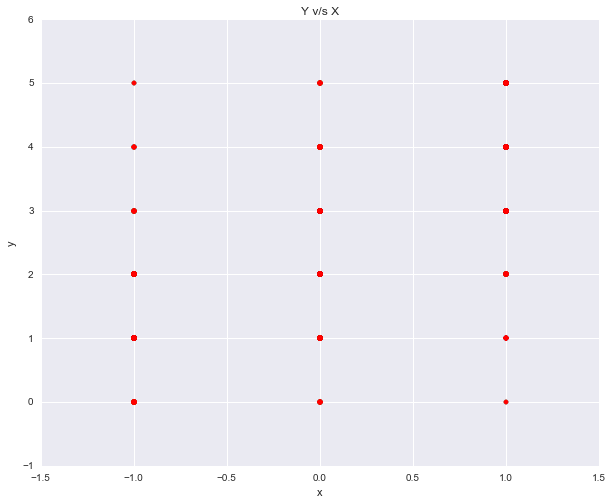

In [24]:
np.random.seed(100)
for i in range(0,6):
    d = run_hmm()
    xt = d['xt']
    yt = d['yt']
    plt.scatter(xt, yt, color=colors[i])
plt.title('Y v/s X')
plt.xlabel('x')
plt.ylabel('y')

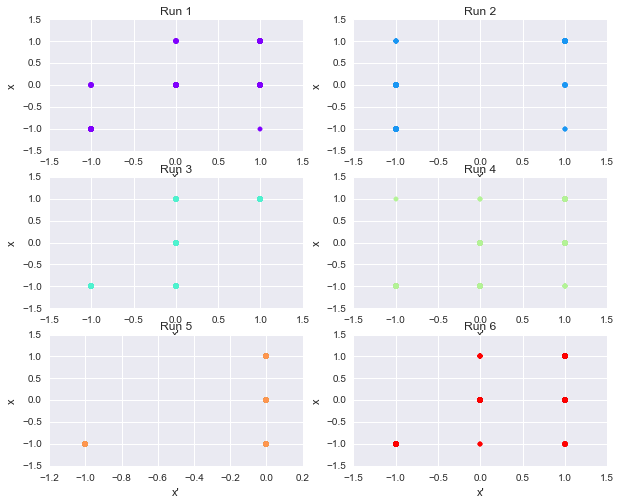

In [25]:
fig = plt.figure()
np.random.seed(100)
for i in range(0,6):
    d = run_hmm()
    ax = fig.add_subplot(3,2,i+1)
    xt = d['xt']
    yt = d['yt']
    xtp, delta = viterbi(yt)
    plt.scatter(xtp, xt, color=colors[i])
    plt.title('Run {}'.format(i+1))
    plt.xlabel("x'")
    plt.ylabel('x')

\begin{eqnarray*}
\alpha_0(i) = \pi_ib_i(O_0)\ \forall \ i = \{-1,0,1\}\\
\log(\alpha_0(i)) = \log(\pi_ib_i(O_0))\ \forall \ i = \{-1,0,1\}\\
\end{eqnarray*}

Now consider
\begin{eqnarray*}
\alpha_t(i) = \big[\sum_{j=0}^{N-1} \alpha_{t-1}(j)a_{ji} \big] b_i(O_t) \forall \ i  = \{-1,0,1\}\\
\log(\alpha_t(i)) = \log(b_i(O_t)) + \log(\sum_{j=0}^{N-1} \alpha_{t-1}(j)a_{ji}) \ i  = \{-1,0,1\}\\
\end{eqnarray*}

We make use of this property:

$\log(a+b) = \log(e^{\log(a)+\log(b)})$

To obtain in log space:
$$
\log(\alpha_t(i)) = \log(b_i(O_t)) + \log(\sum_{j=0}^{N-1} e^{\log(\alpha_{t-1}(j)) +\log(a_{ji})} ) \ i  = \{-1,0,1\}\\
$$

If we define $\alpha'_t(i) = \log(\alpha_t(i))$
then,


$$
 \alpha'_t(i) = \log(b_i(O_t)) + \log(\sum_{j=0}^{N-1} e^{\alpha'_{t-1}(j) +\log(a_{ji})} ) \ i  = \{-1,0,1\}\\
$$


In [55]:
def alpha_pass():
    alpha = [{} for t in range(0,T)]
    for i in Q:
        alpha[0][i] = log(pi0[i+1]) + log(b(yt[0],i))
    for t in range(1,T):
        for i in Q:
            #print(log(np.sum(np.exp([alpha[t-1][j] + log(A[j+1,i+1]) for j in Q]) )))
            #print((np.exp([alpha[t-1][j] + log(A[j+1,i+1]) for j in Q]) ))
            alpha[t][i] = log(b(yt[t], i))
            s= 0
            for j in Q:
                #print np.exp(alpha[t-1][j] + log(A[j+1,i+1]))
                #np.sum(np.exp([alpha[t-1][j] + log(A[j+1,i+1]) for j in Q]) )
                s += np.exp(alpha[t-1][j] + log(A[j+1,i+1]))
            if s < 10e-20:
                s = 10e-20
            alpha[t][i] += log(s)
    return alpha


def beta_pass():
    beta = [{} for t in range(0,T)]
    for i in Q:
        beta[T-1][i] = 10e-100
    for t in range(T-2,-1,-1):
        for i in Q:
            s = 0
            for j in Q:
                s += log(A[i+1,j+1]) + log(b(yt[t+1], j)) + log(beta[t+1][j])
            if s<10e-100:
                s=10e-100
            beta[t][i] = exp(s)
    
    return beta

alpha = alpha_pass()    
beta = beta_pass()
denominator = sum([alpha[T-1][i]*beta[T-1][i] for i in Q])

posterior = []
posterior

## Part *b()
def POL(alpha):
    at = alpha[T-1]
    po = np.sum(np.exp(POL.values()))
    return po

## Part (c)
def gamma_pass(alpha, beta):
    pol = POL(alpha)
    gamma = [{i: a[i]*b[i]} for a,b in zip(alpha,beta) for i in Q]
    return gamma

## Part (d)

def viterbi(yt):
    delta = [{} for t in range(0,T)]
    path = {}
    for q in Q:
        delta[0][q] = log(pi0[q+1])+(b(yt[0],q)) 
        path[q] = [q]
    #print path
    for t in range(1,T):
        tempath = {}
        for q in Q:
            (Z, state) =  max(( delta[t-1][x] + b(yt[t],q) + log(A[x+1,q+1]),x) for x in Q)
            delta[t][q] = Z
            #print(q,state)
            tempath[q] = path[state]+[q]
        path = tempath
        #print path
    #print(delta)
    (p, state) = max((delta[T-1][q], q) for q in Q)
    #print(p)
    return path[state],delta


## Part (e)

def estimateAB()

In [70]:
beta = {}
beta[i] = {i:1 for i in states}